In [1]:
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
import json
import random
%matplotlib inline

Setting some paths and listing the availible classes.

In [2]:
labelsPath = os.path.join("data/obj.names")
weightsPath = os.path.join("data/yolov3_custom_train_6000.weights")
configPath = os.path.join("data/yolov3_custom_test.cfg")

LABELS = open(labelsPath).read().strip().split("\n")
print(LABELS)

['beans', 'cake', 'candy', 'cereal', 'chips', 'chocolate', 'coffee', 'corn', 'fish', 'flour', 'honey', 'jam', 'juice', 'milk', 'nuts', 'oil', 'pasta', 'rice', 'soda', 'spices', 'sugar', 'tea', 'tomato_sauce', 'vinegar', 'water']


In [3]:
# load trained YOLO object detector
YOLO_detector = cv2.dnn.readNetFromDarknet(configPath,weightsPath)

This is the method for prediction using the model. This function returns the image with added bounding boxes as well as the predicted items in the image and the confidence of each one.

In [4]:
# Predict and display bounding boxes
def predict(image):
    
    img_height = image.shape[0]
    img_width = image.shape[1]
    
    # retrive all output layer names from YOLO
    layer_names = YOLO_detector.getLayerNames()
    # reduce to only the output layer names that are needed
    layer_names = [layer_names[i[0] - 1] for i in YOLO_detector.getUnconnectedOutLayers()]
    
    # perform segmentation on the input image to get a collection of images, called a blob
    segmented_images_blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    YOLO_detector.setInput(segmented_images_blob)
    
    # perform a forward pass of the YOLO object detector, giving us our bounding boxes and associated probabilities
    layerOutputs = YOLO_detector.forward(layer_names)
    
    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.2
    
    # loop through the layer outputs
    for output in layerOutputs:
        # loop through the detections
        for detection in output:

            scores = detection[5:]
            classID = np.argmax(scores) # get index of highest scoring detection
            confidence = scores[classID] # retrieve confidence of best detection

            # filter out weak predictions
            if confidence > threshold:
                # calculate bounding box relative to the size of the image
                centerX = int(detection[0] * img_width)
                centerY = int(detection[1] * img_height)
                width = int(detection[2] * img_width)
                height = int(detection[3] * img_height)

                # calculate top left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # add current box values to lists of bounding box coordinates,
                # confidences, and class IDs
                boxes.append([x, y, width, height])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # remove weak overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)

    return_confidences = []
    return_classIDs = []
    
    # check if any detections are left over
    if len(idxs) > 0:
        # loop through indexes to be kept
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (centerX, centerY) = (boxes[i][0], boxes[i][1])
            (width, height) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            cv2.rectangle(image, (centerX, centerY), (centerX + width, centerY + height), (255,0,0), 2)
            text = "{} {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (centerX + 15, centerY + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            
            return_classIDs.append(classIDs[i])
            return_confidences.append(confidences[i])
            
    return image, return_classIDs, return_confidences

Method for displaying an image in a plot.

In [5]:
def display_image(img):
    figure = plt.figure(figsize = (img.shape[0]/50, img.shape[1]/50))
    plt.axis(False)
    subplot = figure.add_subplot(111)
    subplot.axes.xaxis.set_visible(False)
    subplot.axes.yaxis.set_visible(False)
    subplot.imshow(img)

Here are a few examples of images being predicted on using the model with the results and confidence values. The third image is several images merged together which shows some of the flaws of the model. It sometimes can predict the wrong item with great confidence like with its incorrect spices predictions.



Found food classes:
beans

Confidences
beans: 0.9815040230751038%
beans: 0.8832324147224426%
beans: 0.8110421299934387%


Found food classes:
sugar

Confidences
sugar: 0.9824634194374084%
sugar: 0.9569143056869507%
sugar: 0.8582770228385925%
sugar: 0.23105421662330627%


Found food classes:
water
spices
sugar
milk

Confidences
milk: 0.9875224232673645%
spices: 0.8491576910018921%
spices: 0.7938504219055176%
sugar: 0.5631614327430725%
water: 0.33605992794036865%
water: 0.23897331953048706%


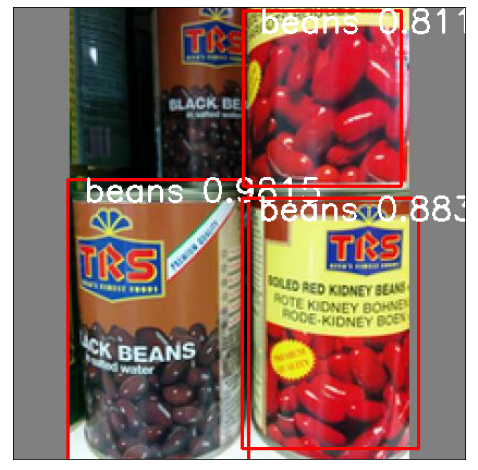

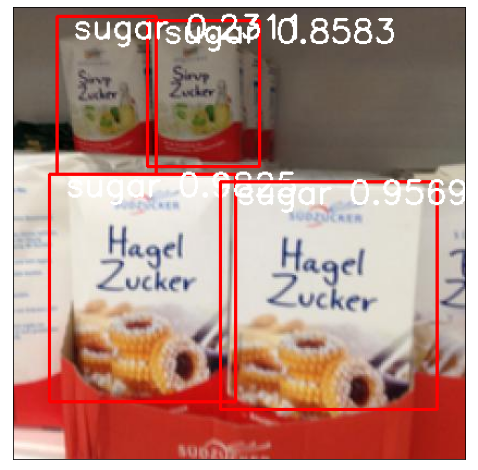

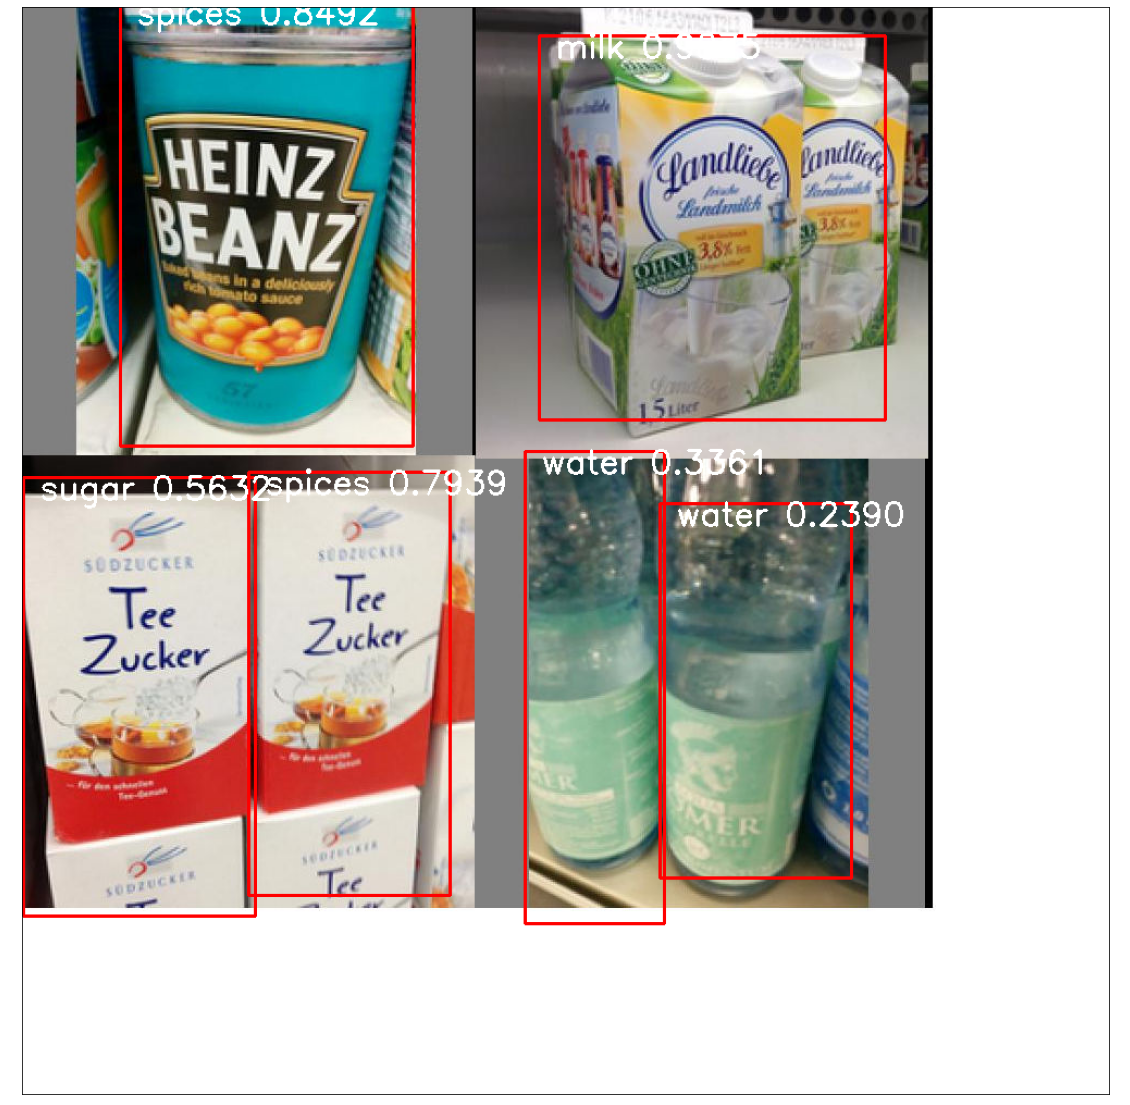

In [6]:
images = ["data/images/BEANS0012_png.rf.2503c5e2a7f24b8aa6c4f25f387c276a.jpg",
         "data/images/SUGAR0012_png.rf.1d247785c79ab0835b8d7ed5cc60a46e.jpg",
         "data/images/image1.jpg"]

for item in images:
    img = cv2.imread(item)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    image, return_classIDs, return_confidences = predict(img)
    display_image(image)

    print("\n\nFound food classes:")
    set_classIDs = set(return_classIDs)
    for id in set_classIDs:
        print(LABELS[id])

    print("\nConfidences")
    for i in range(0,len(return_classIDs)):
        print(str(LABELS[return_classIDs[i]]) + ': ' + str(return_confidences[i]) + '%')

Here is an interactive section that will display possible recipies that can be completed given the ingredients in an image. It pulls these recipies from a small file we created with a few simple examples. This is essentially a proof of concept for what our final goal was.

Text(value='', description='Predict:', placeholder='Type image name here')

Button(description='Go', style=ButtonStyle())

data/images/image2.jpg
Possible recipies:
sugar water
baked beans


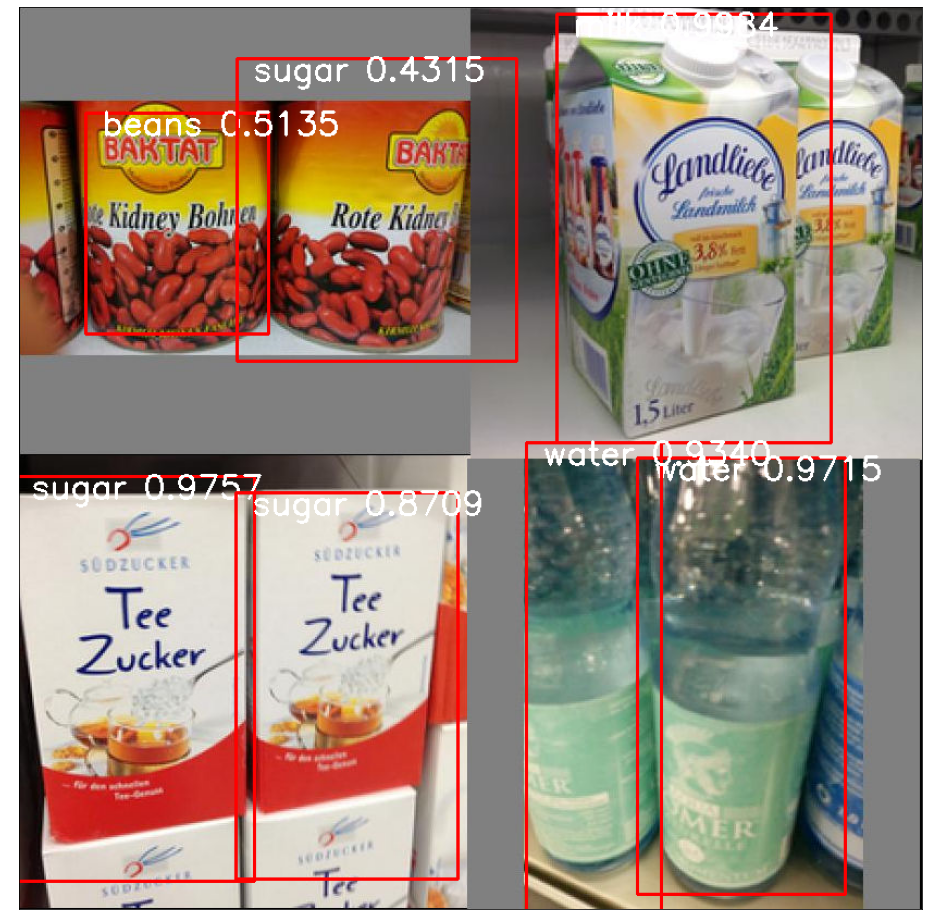

In [7]:
def btn_eventhandler(obj):
    path = "data/images/" + image_name.value
    print(path)
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    image, return_classIDs, return_confidences = predict(img)
    print("Possible recipies:")
    for item in recipies:
        if all(x in return_classIDs for x in item["ids"]):
            print(item["name"])
    display_image(image)
    
image_name = widgets.Text(
    value='',
    placeholder='Type image name here',
    description='Predict:',
    disabled=False
)

f = open('data/recipies.json')
recipies = json.load(f)
btn = widgets.Button(description='Go')
btn.on_click(btn_eventhandler)
display(image_name)
display(btn)

Final notes:
The weights file can be found in this github project https://github.com/bhimar/GrocerEye.
This is also where many of the images we used for testing came from, with a few being taken ourselves and a few from google images.

Overall this project ended up being at a scale we were not fully able to handel, specifically the training of our own model proved dfficult. We were unable to find a suitable database, meaning we would have needed to manually draw bounding boxes around images ourselves. This was not feasable for us, but we managed to find a model trained more specifically on food than the default COCO model. That being said, while this model is less limited than the COCO model, it still does not have all the items in it we would have liked, and we would have liked to create our own model in any case so that we could customize it. The writup has details on some of our efforts to create a model as we learned what doing so really meant.

Reguardless we were able to produce a limited solution to the problem in the end.